In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time
from selenium import webdriver


from emd import emd
from kde.location_project.cmp import geodesic_dist
# from kde.location_project.kde_2d import kdnearest

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
time_span = 'month'
n_visits = 20

# OC Data

In [2]:
# read in the data
oc_directory = os.path.join("..", "data", "oc")
oc_deduped = pd.read_csv(os.path.join(oc_directory, "visits_deduped.csv"))
oc_mpp = pd.read_csv(os.path.join(oc_directory, "mpp_visits_month0a_month1b_n1.csv"))

# location weights based on number of visits
oc_locs = oc_deduped.groupby('location_id')['event_id'].count()
oc_wt_e = pd.DataFrame(oc_locs).reset_index().rename(columns={'event_id': 'weight'})
oc_wt_e['weight'] = 1 / oc_wt_e['weight']

# location weights based on number of unique users at location
oc_locs_users = oc_deduped.groupby(['location_id'])['old_uid'].nunique()
oc_wt_u = pd.DataFrame(oc_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
oc_wt_u['weight'] = 1 / oc_wt_u['weight']

# merge weights in to the point pattern data
oc_deduped = pd.merge(oc_deduped, oc_wt_e, on='location_id')
oc_deduped = pd.merge(oc_deduped, oc_wt_u, on='location_id', suffixes=('_event', '_user'))

# merge weights in to the point pattern data
oc_mpp = pd.merge(oc_mpp, oc_wt_e, on='location_id')
oc_mpp = pd.merge(oc_mpp, oc_wt_u, on='location_id', suffixes=('_event', '_user'))
oc_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,2057.0,1,a,-117.72635,33.60057,6548.0,0.166667,0.166667
1,2057.0,1,b,-117.93499,33.70030,150705.0,0.076923,0.125000
2,25099775.0,1009,b,-117.93504,33.70028,150705.0,0.076923,0.125000
3,2057.0,1,b,-117.83536,33.83125,455162.0,0.029412,0.031250
4,15024696.0,207,a,-117.83569,33.83189,455162.0,0.029412,0.031250


In [3]:
# get counts of events in A & B
cts = oc_mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"old_uid": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"old_uid": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

# read in the results
oc_rslt_directory = os.path.join("..", "data", "DFRWS_USA", "oc")
slr = pd.read_csv(os.path.join(oc_rslt_directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(oc_rslt_directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(oc_rslt_directory, "lr.csv"))

# add labels 
lr["same-src"] = (lr.a == lr.b).astype(bool)

slr["same-src"] = (slr.a == slr.b).astype(bool)
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr

cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has larger slr


# merge & bin counts
splits = [1, 2, 20, float("inf")]

lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

oc_lr = lr
oc_slr = slr
oc_cmp = cmp

In [4]:
# calculate performance per bin
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score, column='label'):
    return format(round(roc_auc_score(rslt[column], rslt[score]), 3), '.3f')


def performance_stats(x, score_func, column, criteria):
    out = []
    for s in score_func:
        d = {}
        d['score'] = s
        d['auc'] = calc_auc(x, s, column)
        d['tp'], d['fp'] = perf_measure(x[column], x[s] > criteria)
        out.append(d)
    return pd.DataFrame(out)


def cmp_performance_stats(x, score_func, criteria):
    out = []
    for s in score_func:
        d = {}
        d['score'] = s
        d['auc'] = calc_auc(x, s, 'label')
        d['tp'], d['fp'] = perf_measure(x['same-src'], x[s] < criteria)
        out.append(d)
    return pd.DataFrame(out)

In [5]:
lr_rslt = lr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, ['lr_alpha_vary', 'lr_alpha_80'], 'same-src', 0) 
).reset_index()
lr_rslt['method'] = 'lr'
lr_rslt.drop(columns='level_2', inplace=True)


scores = ['ied_mn', 'ied_mn_wt_event', 'ied_mn_wt_user', 'emd', 'emd_wt_event', 'emd_wt_user']
slr_rslt = slr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, scores, 'same-src', 1) 
).reset_index()
slr_rslt['method'] = 'slr'
slr_rslt.drop(columns='level_2', inplace=True)


cmp_rslt = cmp.groupby(['bin_a', 'bin_b']).apply(
    lambda x: cmp_performance_stats(x, scores, 0.05) 
).reset_index()
cmp_rslt['method'] = 'cmp'
cmp_rslt.drop(columns='level_2', inplace=True)


# combine them
oc_rslt = pd.concat([lr_rslt, slr_rslt, cmp_rslt], ignore_index=True)
oc_rslt = oc_rslt.sort_values(by=['bin_a', 'bin_b', 'method', 'score'])
oc_rslt = oc_rslt.astype({'auc': float, 'tp': float, 'fp': float})

In [6]:
# simplify results for DFRWS
sc = ['emd_wt_user', 'lr_alpha_80']
oc_simple = oc_rslt.loc[(oc_rslt.bin_a == oc_rslt.bin_b) & 
                  (oc_rslt.score.isin(sc)) & 
                  (oc_rslt.method != 'cmp')]
oc_simple['x'] = oc_simple.bin_a.cat.codes
oc_simple

,bin_a,bin_b,score,auc,tp,fp,method,x
1,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_80,0.666,0.187,0.018,lr,0
23,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.690,0.539,0.257,slr,0
9,"[2.0, 20.0)","[2.0, 20.0)",lr_alpha_80,0.744,0.383,0.042,lr,1
47,"[2.0, 20.0)","[2.0, 20.0)",emd_wt_user,0.817,0.639,0.143,slr,1
17,"[20.0, inf)","[20.0, inf)",lr_alpha_80,0.978,0.910,0.007,lr,2
71,"[20.0, inf)","[20.0, inf)",emd_wt_user,0.969,0.928,0.113,slr,2


# NY Data

In [7]:
# read in the data
ny_directory = os.path.join("..", "data", "ny")
ny_deduped = pd.read_csv(os.path.join(ny_directory, "visits_deduped.csv"))
ny_mpp = pd.read_csv(os.path.join(ny_directory, "mpp_visits_month0a_month1b_n1.csv"))

# location weights based on number of visits
ny_locs = ny_deduped.groupby('location_id')['event_id'].count()
ny_wt_e = pd.DataFrame(ny_locs).reset_index().rename(columns={'event_id': 'weight'})
ny_wt_e['weight'] = 1 / ny_wt_e['weight']

# location weights based on number of unique users at location
ny_locs_users = ny_deduped.groupby(['location_id'])['old_uid'].nunique()
ny_wt_u = pd.DataFrame(ny_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
ny_wt_u['weight'] = 1 / ny_wt_u['weight']

# merge weights in to the point pattern data
ny_deduped = pd.merge(ny_deduped, ny_wt_e, on='location_id')
ny_deduped = pd.merge(ny_deduped, ny_wt_u, on='location_id', suffixes=('_event', '_user'))

# merge weights in to the point pattern data
ny_mpp = pd.merge(ny_mpp, ny_wt_e, on='location_id')
ny_mpp = pd.merge(ny_mpp, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
ny_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,418.0,1,a,-73.99384,40.72405,4962.0,0.003774,0.004237
1,418.0,1,a,-73.99384,40.72405,4962.0,0.003774,0.004237
2,418.0,1,b,-73.99384,40.72405,4962.0,0.003774,0.004237
3,418.0,1,b,-73.99384,40.72405,4962.0,0.003774,0.004237
4,15455345.0,754,b,-73.99383,40.72408,4962.0,0.003774,0.004237


In [8]:
# get counts of events in A & B
cts = ny_mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"old_uid": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"old_uid": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

# read in the results
oc_rslt_directory = os.path.join("..", "data", "DFRWS_USA", "ny")
slr = pd.read_csv(os.path.join(oc_rslt_directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(oc_rslt_directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(oc_rslt_directory, "lr.csv"))

# add labels 
lr["same-src"] = (lr.a == lr.b).astype(bool)

slr["same-src"] = (slr.a == slr.b).astype(bool)
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr

cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has larger slr


# merge & bin counts
splits = [1, 2, 20, float("inf")]

lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

ny_lr = lr
ny_slr = slr
ny_cmp = cmp

In [9]:
lr_rslt = lr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, ['lr_alpha_vary', 'lr_alpha_80'], 'same-src', 0) 
).reset_index()
lr_rslt['method'] = 'lr'
lr_rslt.drop(columns='level_2', inplace=True)


scores = ['ied_mn', 'ied_mn_wt_event', 'ied_mn_wt_user', 'emd', 'emd_wt_event', 'emd_wt_user']
slr_rslt = slr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, scores, 'same-src', 1) 
).reset_index()
slr_rslt['method'] = 'slr'
slr_rslt.drop(columns='level_2', inplace=True)


cmp_rslt = cmp.groupby(['bin_a', 'bin_b']).apply(
    lambda x: cmp_performance_stats(x, scores, 0.05) 
).reset_index()
cmp_rslt['method'] = 'cmp'
cmp_rslt.drop(columns='level_2', inplace=True)


# combine them
ny_rslt = pd.concat([lr_rslt, slr_rslt, cmp_rslt], ignore_index=True)
ny_rslt = ny_rslt.sort_values(by=['bin_a', 'bin_b', 'method', 'score'])
ny_rslt = ny_rslt.astype({'auc': float, 'tp': float, 'fp': float})

In [10]:
# simplify results for DFRWS
sc = ['emd_wt_user', 'lr_alpha_80']
ny_simple = ny_rslt.loc[(ny_rslt.bin_a == ny_rslt.bin_b) & 
                  (ny_rslt.score.isin(sc)) & 
                  (ny_rslt.method != 'cmp')]
ny_simple['x'] = ny_simple.bin_a.cat.codes
ny_simple

,bin_a,bin_b,score,auc,tp,fp,method,x
1,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_80,0.602,0.264,0.141,lr,0
23,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.623,0.484,0.299,slr,0
9,"[2.0, 20.0)","[2.0, 20.0)",lr_alpha_80,0.641,0.231,0.036,lr,1
47,"[2.0, 20.0)","[2.0, 20.0)",emd_wt_user,0.681,0.540,0.260,slr,1
17,"[20.0, inf)","[20.0, inf)",lr_alpha_80,0.972,0.853,0.033,lr,2
71,"[20.0, inf)","[20.0, inf)",emd_wt_user,0.882,0.801,0.173,slr,2


# Plot Defaults

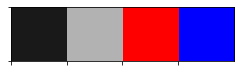

In [11]:
import matplotlib

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    matplotlib.rc("font", family="Times New Roman")

    
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        # [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        # [0.9, 0.9, 0.9],          # light gray
        'red',                     
        'blue'
    ])
        
        
def set_size(fig, w=6, h=3):
    fig.set_size_inches(w, h)
    plt.tight_layout()

    
sns.palplot(get_colors())

# Figure 1

In [12]:
import branca.colormap as cm
from branca.element import Template, MacroElement
from collections import defaultdict
import folium
from folium.plugins import HeatMap, MarkerCluster


def calc_freqs(df):
    ### grid the population data for OC & count visits in each bin
    data = df.copy()
    data["lat_r"] = data.lat.round(3)
    data["lon_r"] = data.lon.round(3)
    freqs = (
        data.groupby(["lat_r", "lon_r"]).count().reset_index()[["lat_r", "lon_r", "event_id"]]
    )
    freqs.columns = ["lat_r", "lon_r", "freq"]
    return freqs


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def make_user_scatter_plot(mpp, uid, mark):
    user = get_user(mpp, uid, mark)
    return list(zip(user.lat, user.lon))


def plot_heat_and_scatter(freqs, mpp, uid, loc, uidB=None, heat=True):
    if uidB is None:
        uidB = uid
    if heat:
        col = 'lightgreen'
        opacity = 0.8
    else:
        col = 'red'
        opacity = 0.75
    
    ### make the map
    if loc == 'oc':
        hmap = folium.Map(
            location=[33.68, -117.78],
            width='85%', 
            zoom_start=10.5, 
            zoom_control=False,
            tiles='CartoDB positron',
        )
    elif loc == 'oc_vignette':
        hmap = folium.Map(
            location=[33.568, -117.713],
            width='90%',
            zoom_start=15, 
            zoom_control=False,
            tiles='CartoDB positron',
        )
    elif loc =='ny':
        hmap = folium.Map(
            location=[40.75, -74],
            width='90%', 
            zoom_start=13.4,
            zoom_control=False,
            tiles='CartoDB positron',
        )
    
    ### make the heatmap
    if heat:
        steps = 20
        color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

        gradient_map = defaultdict(dict)
        for i in range(steps):
            gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

        if loc in {'oc', 'oc_vignette'}:
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=25, 
                blur=16, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        if loc == 'ny':
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=20, 
                blur=12, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        hmap.add_child(heat)
        hmap.add_child(color_map)

    ### make the scatters
    f = folium.map.FeatureGroup()
    for pt in make_user_scatter_plot(mpp, uid, 'a'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color='black',
                fill_opacity=0.75)
        )

    for pt in make_user_scatter_plot(mpp, uidB, 'b'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color=col,
                fill_opacity=opacity)
        )
    hmap.add_child(f)

    ### add legend
    macro = MacroElement()
    macro._template = Template(template)
    hmap.get_root().add_child(macro)

    return hmap


def map_to_png(m, filename):
    fn='figs/tempmap.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    m.save(fn)

    driver = webdriver.Chrome()
    # driver.set_window_size(400, 300)  # choose a resolution
    driver.get(tmpurl)

    time.sleep(5)  # give the map tiles some time to load
    driver.save_screenshot(filename)
    driver.quit()

### (A) Same source
See DFRWS_USA_2020_Orange_County for the associated LR value...

In [13]:
### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:24px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>Unkown Source</li>
    <li><span style='background:red;'></span>Known Source 1</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

uA = 5192
m = plot_heat_and_scatter(
    freqs=None, 
    mpp=oc_mpp, 
    uid=uA, 
    loc='oc_vignette', 
    heat=False
)
# map_to_png(m, 'figs/1a.png')

m

#### Do without map to preserve privacy

In [14]:
import pyproj
from shapely import ops
from shapely.geometry import shape, Polygon
from shapely.geometry.polygon import LinearRing

co = {"type": "Polygon", 
      "coordinates": [[
          (-117.735, 33.559), 
          (-117.690, 33.559),
          (-117.690, 33.578), 
          (-117.735, 33.578),
          (-117.735, 33.559)
      ]]
     }
lon, lat = zip(*co['coordinates'][0])

pa = pyproj.Proj(
    "+proj=aea +lat_1=33.559 +lat_2=33.578 +lat_0=33.5685 +lon_0=-117.7125"
)

x, y = pa(lon, lat)
cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
area = shape(cop).area/10**6
print(round(area, 2), "sq km")
print(round(area/2.59, 2), "sq mi")

8.81 sq km
3.4 sq mi


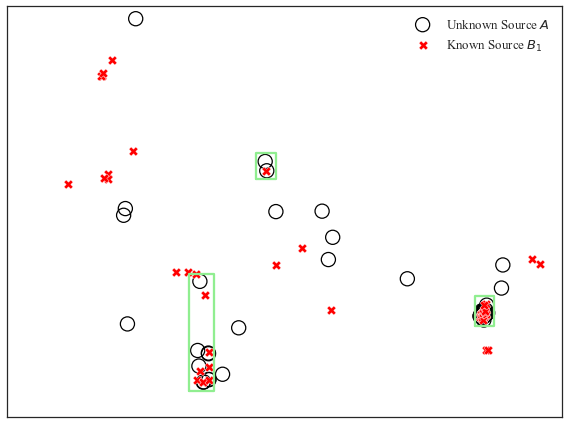

In [15]:
# get the locations of overlap
# matches_a = oc_mpp.loc[
#     (oc_mpp.uid == uA) &
#     (oc_mpp.m == 'a') &
#     (oc_mpp.location_id.isin(
#         oc_mpp.loc[
#             (oc_mpp.uid == uA) &
#             (oc_mpp.m == 'b')
#         ].location_id.unique()
#     ))
# ]

# matches_b = oc_mpp.loc[
#     (oc_mpp.uid == uA) &
#     (oc_mpp.m == 'b') &
#     (oc_mpp.location_id.isin(
#         oc_mpp.loc[
#             (oc_mpp.uid == uA) &
#             (oc_mpp.m == 'a')
#         ].location_id.unique()
#     ))
# ]

# matches = pd.concat([matches_a, matches_b])

# merge_locs = [347495.0, 347496.0, 347497.0, 347505.0, 347506.0, 347507.0, 347518.0]
# matches['new_loc'] = matches['location_id']
# matches.loc[matches['location_id'].isin(merge_locs), 'new_loc'] = -1

# polys = matches.groupby('new_loc')[['lon', 'lat']].apply(
#     lambda x: LinearRing(x.values.tolist() + [x.values[0]])
# )
# polys

plot_polys = []

plot_polys.append(
    LinearRing([
        (-117.72027, 33.5602),
        (-117.7182, 33.5602),
        (-117.7182, 33.5656),
        (-117.72027, 33.5652),
        (-117.72027, 33.5602)
    ])
)

plot_polys.append(
    LinearRing([
        (-117.697,  33.5632),
        (-117.6955, 33.5632),
        (-117.6955, 33.5646),
        (-117.697,  33.5646),
        (-117.697,  33.5632)
    ])
)

plot_polys.append(
    LinearRing([
        (-117.7148, 33.570),
        (-117.7132, 33.570),
        (-117.7132, 33.5712),
        (-117.7148, 33.5712),
        (-117.7148, 33.570)
    ])
)

# create data frame
pts_a = pd.DataFrame(
    make_user_scatter_plot(oc_mpp, uA, 'a'),
    columns=['lat', 'lon']
)
pts_a['m'] = 'A'

pts_b = pd.DataFrame(
    make_user_scatter_plot(oc_mpp, uA, 'b'),
    columns=['lat', 'lon']
)
pts_b['m'] = 'B'

plot_data = pd.concat([pts_a, pts_b])

# plot it
set_style()
sns.set_palette(np.array([get_colors()[0], get_colors()[2]]))

f, ax = plt.subplots()

# sns.scatterplot(
#     x='lon',
#     y='lat',
#     style='m',
#     hue='m',
#     data=plot_data,
#     markers=['o', 'X'],
# #     alpha=0.75
# )

plt.scatter(
    x = plot_data['lon'].loc[plot_data.m == 'A'],
    y = plot_data['lat'].loc[plot_data.m == 'A'],
    facecolors='none',
    edgecolors='black',
    s=200,
    linewidths=1.25,
    label='Unknown Source $A$'
)

plt.scatter(
    x = plot_data['lon'].loc[plot_data.m == 'B'],
    y = plot_data['lat'].loc[plot_data.m == 'B'],
    marker='X',
    c='red',
    label='Known Source $B_1$',
    edgecolors='white',
)

for p in plot_polys:
    plt.plot(
        *p.envelope.exterior.xy,
        color='lightgreen'
    )

ax.set_xlim((-117.735, -117.69))
ax.set_ylim((33.559, 33.578))

# handles, labels = ax.get_legend_handles_labels()
# labels[1] = 'Unknown Source $A$'
# labels[2] = 'Known Source $B_1$'
# ax.legend(handles=handles[1:], labels=labels[1:])
ax.legend()

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, w=8, h=6)

plt.savefig('./figs/1a.eps', dpi=500)

plt.show()

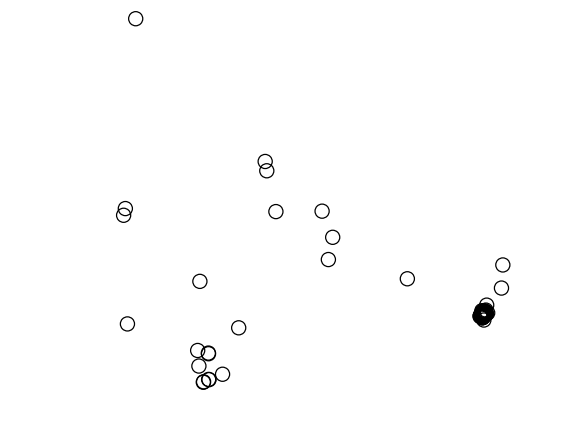

In [23]:
# plot it
set_style()
sns.set_palette(np.array([get_colors()[0], get_colors()[2]]))

f, ax = plt.subplots()

plt.scatter(
    x = plot_data['lon'].loc[plot_data.m == 'A'],
    y = plot_data['lat'].loc[plot_data.m == 'A'],
    facecolors='none',
    edgecolors='black',
    s=200,
    linewidths=1.25,
    label='Unknown Source $A$'
)

ax.set_xlim((-117.735, -117.69))
ax.set_ylim((33.559, 33.578))
ax.axis('off')

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, w=8, h=6)

plt.savefig('./figs/motivating_example_unknown.eps', dpi=500)

plt.show()

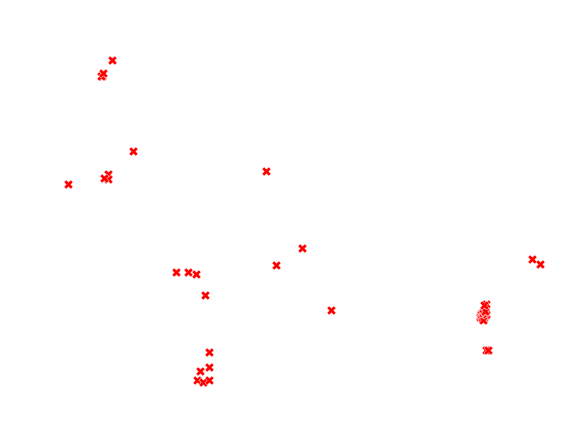

In [24]:
# plot it
set_style()
sns.set_palette(np.array([get_colors()[0], get_colors()[2]]))

f, ax = plt.subplots()

plt.scatter(
    x = plot_data['lon'].loc[plot_data.m == 'B'],
    y = plot_data['lat'].loc[plot_data.m == 'B'],
    marker='X',
    c='red',
    label='Known Source $B_1$',
    edgecolors='white',
)

ax.set_xlim((-117.735, -117.69))
ax.set_ylim((33.559, 33.578))
ax.axis('off')

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, w=8, h=6)

plt.savefig('./figs/motivating_example_same_B.eps', dpi=500)

plt.show()

### (B) Different source
See DFRWS_USA_2020_Orange_County for the associated LR value...

In [26]:
### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:24px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>Unkown Source</li>
    <li><span style='background:red;'></span>Known Source 2</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

uB = 5606
m = plot_heat_and_scatter(
    freqs=None,
    mpp=oc_mpp, 
    uid=uA, 
    uidB=uB, 
    loc='oc_vignette', 
    heat=False
)
# map_to_png(m, 'figs/1b.png')

m

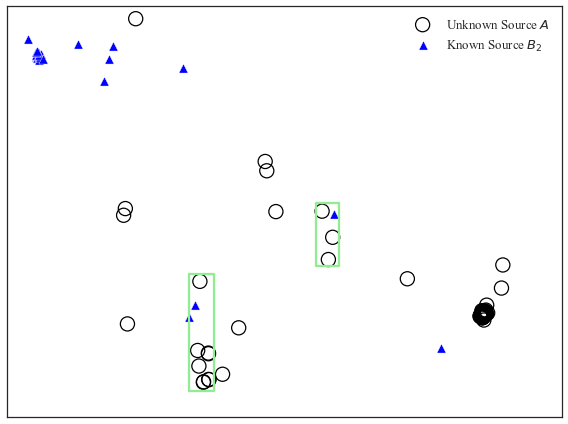

In [27]:
# get the locations of overlap
# matches_a = oc_mpp.loc[
#     (oc_mpp.uid == uA) &
#     (oc_mpp.m == 'a') &
#     (oc_mpp.location_id.isin(
#         oc_mpp.loc[
#             (oc_mpp.uid == uB) &
#             (oc_mpp.m == 'b')
#         ].location_id.unique()
#     ))
# ]

# matches_b = oc_mpp.loc[
#     (oc_mpp.uid == uB) &
#     (oc_mpp.m == 'b') &
#     (oc_mpp.location_id.isin(
#         oc_mpp.loc[
#             (oc_mpp.uid == uA) &
#             (oc_mpp.m == 'a')
#         ].location_id.unique()
#     ))
# ]

# matches = pd.concat([matches_a, matches_b])


# polys = matches.groupby('location_id')[['lon', 'lat']].apply(
#     lambda x: LinearRing(x.values.tolist())
# )

plot_polys = [plot_polys[0]]

plot_polys.append(
    LinearRing([
        (-117.7099, 33.566),
        (-117.7081, 33.566),
        (-117.7081, 33.5689),
        (-117.7099, 33.5689),
        (-117.7099, 33.566)
    ])
)

# create data frame
pts_a = pd.DataFrame(
    make_user_scatter_plot(oc_mpp, uA, 'a'),
    columns=['lat', 'lon']
)
pts_a['m'] = 'A'

pts_b = pd.DataFrame(
    make_user_scatter_plot(oc_mpp, uB, 'b'),
    columns=['lat', 'lon']
)
pts_b['m'] = 'B'

plot_data = pd.concat([pts_a, pts_b])

# plot it
set_style()
sns.set_palette(np.array([get_colors()[0], get_colors()[3]]))

f, ax = plt.subplots()

# sns.scatterplot(
#     x='lon',
#     y='lat',
#     style='m',
#     hue='m',
#     data=plot_data,
#     markers=['o','^'],
# #     alpha=0.75
# )

plt.scatter(
    x = plot_data['lon'].loc[plot_data.m == 'A'],
    y = plot_data['lat'].loc[plot_data.m == 'A'],
    facecolors='none',
    edgecolors='black',
    s=200,
    linewidths=1.25,
    label='Unknown Source $A$'
)

plt.scatter(
    x = plot_data['lon'].loc[plot_data.m == 'B'],
    y = plot_data['lat'].loc[plot_data.m == 'B'],
    marker='^',
    c='blue',
    label='Known Source $B_2$',
    edgecolors='white',
)

for p in plot_polys:
    plt.plot(
        *p.envelope.exterior.xy,
        color='lightgreen'
    )
    
ax.set_xlim((-117.735, -117.69))
ax.set_ylim((33.559, 33.578))

# handles, labels = ax.get_legend_handles_labels()
# labels[1] = 'Unknown Source $A$'
# labels[2] = 'Known Source $B_2$'
# ax.legend(handles=handles[1:], labels=labels[1:])
ax.legend()

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, w=8, h=6)

plt.savefig('./figs/1b.eps', dpi=500)

plt.show()

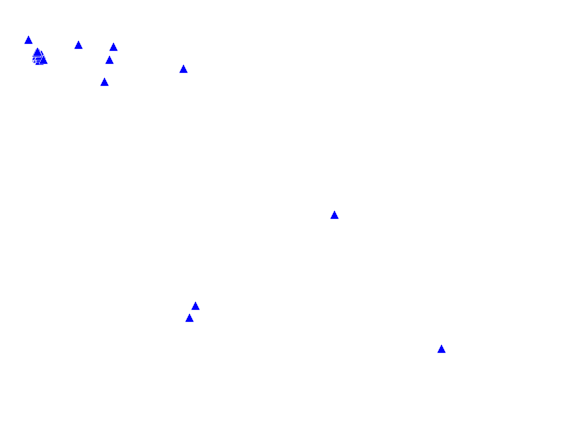

In [29]:
# plot it
set_style()
sns.set_palette(np.array([get_colors()[0], get_colors()[2]]))

f, ax = plt.subplots()

plt.scatter(
    x = plot_data['lon'].loc[plot_data.m == 'B'],
    y = plot_data['lat'].loc[plot_data.m == 'B'],
    marker='^',
    c='blue',
    label='Known Source $B_2$',
    edgecolors='white',
)

ax.set_xlim((-117.735, -117.69))
ax.set_ylim((33.559, 33.578))
ax.axis('off')

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, w=8, h=6)

plt.savefig('./figs/motivating_example_diff_B.eps', dpi=500)

plt.show()

# Figure 2

In [18]:
### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:24px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>A</li>
    <li><span style='background:red;'></span>B</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [19]:
m = plot_heat_and_scatter(
    freqs=None, 
    mpp=ny_mpp, 
    uid=150, 
    loc='ny', 
    heat=False
)
m

In [20]:
map_to_png(m, 'figs/2.png')

# Figure 3

In [21]:
from kde.location_project.kde_2d import (
    KDE,
    MixtureKDE,
    create_individual_component_data,
)

# create the population KDE
filepath = os.path.join("..", "data", "DFRWS_USA", "oc", "population_visits_kde_data.npy")
pop_kde_data = np.load(filepath)
pop_kde = KDE(pop_kde_data)

# create the individual KDE
ind_A = (oc_mpp.uid == uA) & (oc_mpp.m == 'a')
indiv_kde_data = create_individual_component_data(oc_mpp.loc[ind_A, ])
indiv_kde = KDE(indiv_kde_data)

# create the mixture KDE
mix_kde = MixtureKDE(indiv_kde_data, pop_kde_data)


def eval_density(kde, xlim=[-118.2, -117.5], ylim=[33.4, 34], delta = 0.01):
    x = np.arange(xlim[0], xlim[1], delta)  # longitude
    y = np.arange(ylim[0], ylim[1], delta)  # latitude
    X, Y = np.meshgrid(x, y)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    z = np.apply_along_axis(kde.log_pdf, 1, pts)
    Z = np.reshape(z, X.shape)
    return X, Y, Z

# xlim = [-117.735, -117.69]
# ylim = [33.559, 33.579]
# delta = 0.0025
xlim = [-118.13, -117.56]
ylim = [33.36, 33.96] 
delta = 0.005
# X_i, Y_i, Z_i = eval_density(indiv_kde, xlim=xlim, ylim=ylim, delta=delta)
# X_p, Y_p, Z_p = eval_density(pop_kde, xlim=xlim, ylim=ylim, delta=delta)
# X_m, Y_m, Z_m = eval_density(mix_kde, xlim=xlim, ylim=ylim, delta=delta)

### (A) Population

NameError: name 'X_p' is not defined

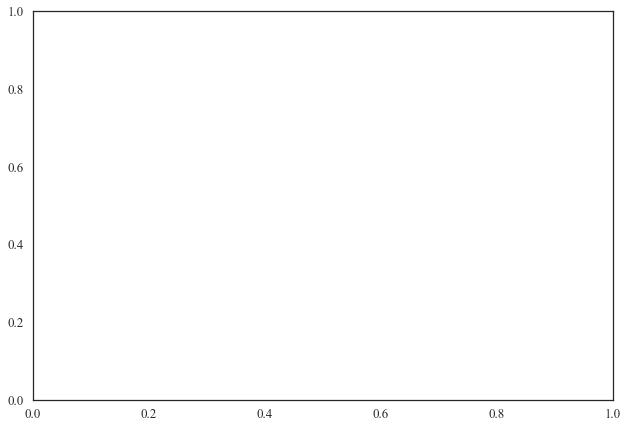

In [22]:
set_style()

f, ax = plt.subplots()

plt.contour(
    X_p, Y_p, Z_p, 
    levels=np.linspace(-30,10,13),
#     cmap='bone',
    extend='min',
)
plt.colorbar()

sns.scatterplot(
    x='lon',
    y='lat',
    data=oc_mpp.loc[ind_A],
    color='red',
    marker='x'
)

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, 8, 6)

plt.savefig('./figs/3a.eps', dpi=500)

plt.show()

### (B) Individual

In [ ]:
set_style()

f, ax = plt.subplots()

plt.contourf(
    X_i, Y_i, Z_i, 
    20,
    cmap='bone')
plt.colorbar()

sns.scatterplot(
    x='lon',
    y='lat',
    data=oc_mpp.loc[ind_A],
    color='red',
    marker='x'
)

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, 8, 6)

plt.savefig('./figs/3b.eps', dpi=500)

plt.show()

### (C) Mixture

In [ ]:
set_style()

f, ax = plt.subplots()

plt.contourf(
    X_m, Y_m, Z_m, 
    50,
    cmap='bone'
)
plt.colorbar()

sns.scatterplot(
    x='lon',
    y='lat',
    data=oc_mpp.loc[ind_A],
    color='red',
    marker='x'
)

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, 8, 6)

plt.savefig('./figs/3c.eps', dpi=500)

plt.show()

# Figure 4
Done in R, see `Documents/DataLab/CSAFE/DFRWS_USA_2020/toy_examples.R`

# Figure 5
## (A) OC

In [ ]:
### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

oc_freqs = calc_freqs(oc_deduped)
m = plot_heat_and_scatter(
    freqs=oc_freqs, 
    mpp=oc_mpp, 
    uid=None, 
    loc='oc'
)
m

In [ ]:
map_to_png(m, 'figs/5a.png')

### (B) NY

In [ ]:
ny_freqs = calc_freqs(ny_deduped)
m = plot_heat_and_scatter(
    freqs=ny_freqs, 
    mpp=ny_mpp, 
    uid=None, 
    loc='ny'
)
m

In [ ]:
map_to_png(m, 'figs/5b.png')

# Figure 6
### (A) OC

In [ ]:
set_style()
sns.set_palette(get_colors())

f, ax = plt.subplots()

sns.barplot(
    x='x', 
    y='fp',
    data=oc_simple,
    hue='method',
)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylim((0,0.35))

legend = plt.legend()
legend.get_texts()[0].set_text('LR')
legend.get_texts()[1].set_text('SLR')

plt.xticks([0,1,2])
plt.xlabel('Amount of Data')
plt.ylabel('False Positive Rate')

set_size(f)

plt.savefig('./figs/6a.eps', dpi=500)

plt.show()

### (B) NY

In [ ]:
set_style()
sns.set_palette(get_colors())

f, ax = plt.subplots()

sns.barplot(
    x='x', 
    y='fp',
    data=ny_simple,
    hue='method',
)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylim((0,0.35))

legend = plt.legend()
legend.get_texts()[0].set_text('LR')
legend.get_texts()[1].set_text('SLR')

plt.xticks([0,1,2])
plt.xlabel('Amount of Data')
plt.ylabel('False Positive Rate')

set_size(f)

plt.savefig('./figs/6b.eps', dpi=500)

plt.show()

# Figure C.1
Taken from Moshe's thesis.

# Figure C.2
### (A) Visits

In [ ]:
set_style()

f, ax = plt.subplots()

ax = sns.kdeplot(
    oc_locs, 
    color = 'black',
    lw=2,
    clip=(0,400),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs, 
    color = 'black',
    linestyle = 'dashed',
    lw=2,
    clip=(0,400),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Visits")

set_size(f, 4, 3)

plt.savefig('./figs/C2a.eps', dpi=500)

plt.show()

### (B) Accounts

In [ ]:
set_style()

f, ax = plt.subplots()

ax = sns.kdeplot(
    oc_locs_users, 
    color = 'black',
    lw=2,
    clip=(0,200),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs_users, 
    color = 'black',
    linestyle = 'dashed',
    lw=2,
    clip=(0,200),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Accounts")

set_size(f, 4, 3)

plt.savefig('./figs/C2b.eps', dpi=500)

plt.show()

# Evaluate population density over grid

In [ ]:
from kde.location_project.kde_2d import (
    KDE,
    MixtureKDE,
    create_individual_component_data,
)


def eval_density(kde, xlim=[-118.2, -117.5], ylim=[33.4, 34], delta = 0.01):
    x = np.arange(xlim[0], xlim[1], delta)  # longitude
    y = np.arange(ylim[0], ylim[1], delta)  # latitude
    X, Y = np.meshgrid(x, y)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    z = np.apply_along_axis(kde.log_pdf, 1, pts)
    Z = np.reshape(z, X.shape)
    return X, Y, Z

## OC

In [ ]:
# # create the population KDE
# directory = os.path.join("..", "data", "DFRWS_USA", "oc")
# pop_kde_data = np.load(os.path.join(directory, "population_visits_kde_data.npy"))
# pop_kde = KDE(pop_kde_data)

# xlim = [-118.13, -117.44]
# ylim = [33.36, 33.96] 
# delta = 0.00125
# X_p, Y_p, Z_p = eval_density(pop_kde, xlim=xlim, ylim=ylim, delta=delta)

In [ ]:
# Z = (Z_p - np.min(Z_p)) / (np.max(Z_p) - np.min(Z_p))
# out = pd.DataFrame(np.stack([X_p.ravel(), Y_p.ravel(), np.exp(Z_p.ravel()), Z.ravel()], axis=1))
# out = out.rename(columns={0:'lon', 1:'lat', 2:'pdf', 3:'scaled_pdf'})
# out.to_csv(os.path.join(directory, 'population_kde_grid.csv'), index=False)

## NY

In [ ]:
# # create the population KDE
# directory = os.path.join("..", "data", "DFRWS_USA", "ny")
# pop_kde_data = np.load(os.path.join(directory, "population_visits_kde_data.npy"))
# pop_kde = KDE(pop_kde_data)

# xlim = [-74.03, -73.89]
# ylim = [40.695, 40.88] 
# delta = 0.0005
# X_p, Y_p, Z_p = eval_density(pop_kde, xlim=xlim, ylim=ylim, delta=delta)

In [ ]:
# Z = (Z_p - np.min(Z_p)) / (np.max(Z_p) - np.min(Z_p))
# out = pd.DataFrame(np.stack([X_p.ravel(), Y_p.ravel(), np.exp(Z_p.ravel()), Z.ravel()], axis=1))
# out = out.rename(columns={0:'lon', 1:'lat', 2:'pdf', 3:'scaled_pdf'})
# out.to_csv(os.path.join(directory, 'population_kde_grid.csv'), index=False)